In [1]:
import numpy as np
import pandas as pd
from math import ceil, floor
from glob import glob
from tqdm.auto import tqdm
import h5py
import os.path
from scipy import stats

import sys
sys.path.insert(1, '/Users/prullens/Documents/GitHub/scChromTools/local/')
import scChromTools as scct
import scChromUtils as sccu

# Functions

In [79]:
def legend_without_duplicate_labels(ax, bbox_to_anchor=(1,1), frameon=True):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), bbox_to_anchor=bbox_to_anchor, frameon=frameon)

In [83]:
def simulate_dynamics(n_obs, switch, direction=1, noise_level=.1, seed=0):
    
    """
    based on  doi: 10.1038/s41587-020-0591-3 
    
    Simulation of dynamics at specified switch.
    
    The parameters for each reaction are randomly sampled from a log-normal distribution
    and time events follow the Poisson law.
    
    Parameters
    ----------
    n_obs : int, number of observations.
    
    switch : float between 0 and 1. Fraction of n_obs at which dynamic starts.
    
    direction : int 1 or -1. 1: upregulated, -1: downregulated dynamic. 
    
    noise_level : float between 0 and 1. 
    
    """
    np.random.seed(seed)
    switch = int(switch * n_obs)
    
    def draw_poisson(n_obs):
        t = np.cumsum([-0.1 * np.log(np.random.uniform(0, 1)) for _ in range(n_obs - 1)])
        return np.insert(t, 0, 0) # prepend t0=0
    
    t = draw_poisson(n_obs)
    t *= direction
    t_switch = np.insert(t, 0, np.repeat(0,switch))[:-switch]
    t_switch = (t_switch - t_switch.min()) / (t_switch.max() - t_switch.min())
    
    def draw_normal(t_switch, noise_level=noise_level):
        return np.hstack([np.random.normal(v, scale=noise_level) for v in t_switch])

    t_normal = draw_normal(t_switch)
    t_normal = (t_normal - t_normal.min()) / (t_normal.max() - t_normal.min())
    
    return t_normal

# Plot settings

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import gaussian, fftconvolve
from matplotlib import ticker as mticker
import pygbrowse
from scipy.ndimage import gaussian_filter
from matplotlib.colors import LinearSegmentedColormap as cmap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import FormatStrFormatter
import matplotlib.colors

plt.rcParams["xtick.major.size"] = 7
plt.rcParams["ytick.major.size"] = 7
plt.matplotlib.rcParams['pdf.fonttype'] = 42
plt.rcParams['figure.dpi'] = 150

import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

boxprops = {
    'boxprops':{'edgecolor':'k','linewidth':1},
    'medianprops':{'color':'k','linewidth':1},
    'whiskerprops':{'color':'k','linewidth':1},
    'capprops':{'color':'k','linewidth':1}
}

coldict = {'ESCs_d0':'#a8cbeb',
           'ES_d0':'#a8cbeb',
           'ES_d0_fromVitaminC':'#a8cbeb', 
           'VitaminC_d2':'#b4dbc6',
           'VitaminC_d3':'#73c09a', 
           'VitaminC_d4':'#168786', 
           'VitaminC_d5':'#146187', 
           'VitaminC_d6':'#04425b',
           'CAST_EiJ':'#3131dd',
           '129S1_SvImJ':'#b72323'
}

# Global variables

In [3]:
CHROMS = [str(i) for i in list(range(1,20)) + ["X"]]
CHROMSIZES = '/Users/prullens/metadata/mm10_chrom_sizes.tsv'
chromsizes = pd.read_csv(CHROMSIZES, sep='\t', header=None).groupby(0)[1].apply(sum).to_dict()

BINSIZE = 100000
SMOOTH_STDDEV = 150000

BLACKLIST = '/Users/prullens/metadata/mm10.blacklist.bed'
EXPECTED = '/Users/prullens/metadata/mm10_mappability_binsize_%i.hdf5' #%BINSIZE

COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

W = gaussian(ceil(SMOOTH_STDDEV / BINSIZE * 6 / 2) * 2 + 1, SMOOTH_STDDEV / BINSIZE)
W /= W.sum()

DAMCASFMT = '/Users/prullens/Documents/projects/DamnChIC/experiments/%s/hdf5/%s.index%02d.DamID2_BC_%03d.129S1_SvImJ_snps_vs_CAST_snps.unique_CAST_snps.top_n_1.event_counts.PE_R1.binsize_100000.hdf5'
DAM129FMT = '/Users/prullens/Documents/projects/DamnChIC/experiments/%s/hdf5/%s.index%02d.DamID2_BC_%03d.129S1_SvImJ_snps_vs_CAST_snps.unique_129S1_SvImJ_snps.top_n_1.event_counts.PE_R1.binsize_100000.hdf5'

CHICCASFMT = '/Users/prullens/Documents/projects/DamnChIC/experiments/%s/hdf5/%s.index%02d.BC_ChIC_%03d.129S1_SvImJ_snps_vs_CAST_snps.unique_CAST_snps.top_n_1.chic.PE_R1.AT_noTC.event_counts.binsize_100000.hdf5'
CHIC129FMT = '/Users/prullens/Documents/projects/DamnChIC/experiments/%s/hdf5/%s.index%02d.BC_ChIC_%03d.129S1_SvImJ_snps_vs_CAST_snps.unique_129S1_SvImJ_snps.top_n_1.chic.PE_R1.AT_noTC.event_counts.binsize_100000.hdf5'

DAMFNFMT = '/Users/prullens/Documents/projects/DamnChIC/experiments/%s/hdf5/%s.index%02d.DamID2_BC_%03d.top_n_2.event_counts.binsize_%i.hdf5'
CHICFNFMT1 = '/Users/prullens/Documents/projects/DamnChIC/experiments/%s/hdf5/%s.index%02d.BC_ChIC_%03d.top_n_1.chic.AT_noTC.event_counts.binsize_%i.hdf5'
CHICFNFMT2 = '/Users/prullens/Documents/projects/DamnChIC/experiments/%s/hdf5/%s.index%02d.BC_ChIC_%03d.top_n_2.chic.AT_noTC.event_counts.binsize_%i.hdf5'

OUTDIR = '/Users/prullens/Documents/manuscripts/Kefalopoulou_2021/figure_XCI/PR20230411/'

# Data

_Metadata_

In [4]:
anno8164 = pd.read_csv('/Users/prullens/Documents/projects/DamnChIC/experiments/KIN8164/KIN8164_anno.tsv', sep='\t')
anno8164.index = ['%s.index%02d.%03d' %(limsid,i,bc) for limsid,i,bc in anno8164[['limsid','indexnr','barcodenr']].values]
anno8164['antibody'] = anno8164['antibody'].str[2:]
anno8164['cell_type'] = anno8164['cell_type'].str.replace('VitCdiff','VitaminC')

In [5]:
anno8403 = pd.read_csv('/Users/prullens/Documents/projects/DamnChIC/experiments/KIN8403/KIN8403_anno.tsv', sep='\t')
anno8403 = anno8403[~anno8403['indexnr'].isin([31,32,33,34])].copy()
anno8403.index = ['%s.index%02d.%03d' %(limsid,i,bc) for limsid,i,bc in anno8403[['limsid','indexnr','barcodenr']].values]

In [6]:
anno8433_xci = pd.read_csv('/Users/prullens/Documents/projects/DamnChIC/experiments/KIN8433_xci/KIN8433_anno_Xi.tsv', sep='\t')
anno8433_xci.index = ['%s.index%02d.%03d' %(limsid,i,bc) for limsid,i,bc in anno8433_xci[['limsid','indexnr','barcodenr']].values]

In [7]:
anno8791 = pd.read_csv('/Users/prullens/Documents/projects/DamnChIC/experiments/KIN8791_xci/KIN8791_anno_Xi.tsv', sep='\t')
anno8791.index = ['KIN8791_KIN8928_xci.index{:02d}.{:03d}'.format(i,bc) for i,bc in anno8791[['indexnr','barcodenr']].values]

idxs = [21,22,23,27,28,29,36,37] #only parse Dam-lb1/k9me3 & Dam-k27/lb1 data
anno8791 = pd.DataFrame(anno8791[anno8791['indexnr'].isin(idxs)])

anno8791['limsid'] = 'KIN8791_KIN8928_xci'

In [8]:
anno10644 = pd.read_csv('/Users/prullens/Documents/projects/DamnChIC/experiments/KIN10644/KIN10644_anno.tsv', sep='\t')
anno10644.index = ['KIN10644.index{:02d}.{:03d}'.format(i,bc) for i,bc in anno10644[['indexnr','barcodenr']].values]
anno10644 = anno10644[(anno10644['cell_type'] == 'ESCs_d0') | (anno10644['cell_type'].str.startswith('VitaminC'))].copy()
anno10644 = anno10644[(anno10644['construct'] == 'Dam-scFv-K27me3') & (anno10644['antibody'] == 'H2AK119Ub')].copy()
anno10644 = anno10644.loc[:,anno8791.columns].copy()

In [9]:
anno = pd.concat([anno8164,anno8403,anno8433_xci,anno8791,anno10644])

anno.shape

(13824, 13)

In [10]:
constructs = ['Dam-LmnB1','Dam-scFv-K27me3']
antibodies = ['K27me3','K9me3','LmnB1','H2AK119Ub']

anno = anno[~anno['cell_type'].str.contains('NPC')].copy()
anno = anno[anno['construct'].isin(constructs) & anno['antibody'].isin(antibodies)]

anno.shape

(8448, 13)

_Xi dynamic regions_

In [11]:
lb1_k27_idx = pd.read_csv('/Users/prullens/Documents/projects/DamnChIC/experiments/KIN8164/PR20230209.chrx_lb1_k27_changing_bins_100kb.tsv', header=None)[0].values

lb1_k27_idx.sum()

711

_pygBrowse_

In [12]:
genemodels = pygbrowse.datasources.Gff3Annotations('/Users/prullens/metadata/Mus_musculus.GRCm38.93.chr.gff3.bgzf', 
                                                   component_types=('CDS','three_prime_UTR', 'five_prime_UTR')
)
genemodel_plotter = pygbrowse.plots.GeneModelPlot(genemodels, 
                                                  color='k', 
                                                  chevron_width=0.04,
                                                  chevron_linewidth=.6,
                                                  chevron_spacing=.4, 
                                                  gene_name_fontsize=4
)

_DamID_

In [13]:
hdf5_list = [DAMCASFMT %(limsid,limsid,i,bc) for limsid,i,bc in anno[['limsid','indexnr','barcodenr']].values]
hdf5_list = [fn for fn in hdf5_list if os.path.isfile(fn)]

oe_dam_cas, depths = scct.compute_oe(hdf5_list, 
                                     BINSIZE, 
                                     CHROMSIZES, 
                                     depth_thrs=200, 
                                     expected=EXPECTED %BINSIZE, 
                                     blacklist=BLACKLIST, 
                                     chroms=CHROMS
)
anno['dam_counts_cas'] = [depths[bc] if bc in depths else 0 for bc in anno.index]

len(oe_dam_cas)

  0%|          | 0/8447 [00:00<?, ?it/s]

7947

In [14]:
hdf5_list = [DAM129FMT %(limsid,limsid,i,bc) for limsid,i,bc in anno[['limsid','indexnr','barcodenr']].values]
hdf5_list = [fn for fn in hdf5_list if os.path.isfile(fn)]

oe_dam_129, depths = scct.compute_oe(hdf5_list, 
                                     BINSIZE, 
                                     CHROMSIZES, 
                                     depth_thrs=200, 
                                     expected=EXPECTED %BINSIZE,
                                     blacklist=BLACKLIST, 
                                     chroms=CHROMS,
)
anno['dam_counts_129'] = [depths[bc] if bc in depths else 0 for bc in anno.index]

len(oe_dam_129)

  0%|          | 0/8447 [00:00<?, ?it/s]

8034

_ChIC_

In [15]:
hdf5_list = [CHICCASFMT %(limsid,limsid,i,bc) for limsid,i,bc in anno[['limsid','indexnr','barcodenr']].values]
hdf5_list = [fn for fn in hdf5_list if os.path.isfile(fn)]

oe_chic_cas, depths = scct.compute_oe(hdf5_list, 
                                      BINSIZE, 
                                      CHROMSIZES, 
                                      depth_thrs=200, 
                                      expected=EXPECTED %BINSIZE, 
                                      blacklist=BLACKLIST, 
                                      chroms=CHROMS,
)
anno['chic_counts_cas'] = [depths[bc] if bc in depths else 0 for bc in anno.index]

len(oe_chic_cas)

  0%|          | 0/8445 [00:00<?, ?it/s]

7115

In [16]:
hdf5_list = [CHIC129FMT %(limsid,limsid,i,bc) for limsid,i,bc in anno[['limsid','indexnr','barcodenr']].values]
hdf5_list = [fn for fn in hdf5_list if os.path.isfile(fn)]

oe_chic_129, depths = scct.compute_oe(hdf5_list, 
                                      BINSIZE, 
                                      CHROMSIZES, 
                                      depth_thrs=200, 
                                      expected=EXPECTED %BINSIZE, 
                                      blacklist=BLACKLIST, 
                                      chroms=CHROMS,
)
anno['chic_counts_129'] = [depths[bc] if bc in depths else 0 for bc in anno.index]

len(oe_chic_129)

  0%|          | 0/8445 [00:00<?, ?it/s]

7163

# Plotting

# Dam-Lmnb1 & K27me3 - VitaminC

In [17]:
construct = 'Dam-LmnB1'
antibody = 'K27me3'
cell_type = 'VitaminC'

In [19]:
anno_sub = anno.loc[(anno.index.isin(list(oe_dam_cas)) & 
                     anno.index.isin(list(oe_dam_129)) & 
                     anno.index.isin(list(oe_chic_cas)) & 
                     anno.index.isin(list(oe_chic_129)))
]
anno_sub.shape

(7084, 17)

In [20]:
anno_sub = pd.DataFrame(anno_sub[(anno_sub['construct'] == construct) &
                                 (anno_sub['antibody'] == antibody) & 
                                 (anno_sub['cell_type'].str.contains(cell_type))]
)

anno_sub.shape

(1992, 17)

In [21]:
umap_pt = pd.read_csv('/Users/prullens/Documents/projects/DamnChIC/experiments/PR20230331.vitc_k27_umap_pseudotime.csv', index_col=0)

In [22]:
umap_pt = umap_pt[umap_pt.index.isin(anno_sub.index)]

umap_pt.shape

(1656, 3)

In [23]:
anno_sub[['UMAP_1','UMAP_2','pseudotime']] = np.nan
anno_sub.loc[umap_pt.index,['UMAP_1','UMAP_2','pseudotime']] = umap_pt.values

In [24]:
anno_sub = pd.DataFrame(anno_sub[~anno_sub['UMAP_1'].isna()])

anno_sub.shape

(1656, 20)

In [25]:
anno_sub = anno_sub.sort_values('pseudotime')

In [26]:
gb = anno_sub.groupby(['construct','antibody','cell_type'])

gb.size().to_frame('Cells')

Cells
construct antibody cell_type                
Dam-LmnB1 K27me3   ES_d0_fromVitaminC    296
                   VitaminC_d2           277
                   VitaminC_d3           267
                   VitaminC_d4           258
                   VitaminC_d5           261
                   VitaminC_d6           297

In [27]:
bc_dict = gb.groups

list(bc_dict), len(bc_dict)

([('Dam-LmnB1', 'K27me3', 'ES_d0_fromVitaminC'),
  ('Dam-LmnB1', 'K27me3', 'VitaminC_d2'),
  ('Dam-LmnB1', 'K27me3', 'VitaminC_d3'),
  ('Dam-LmnB1', 'K27me3', 'VitaminC_d4'),
  ('Dam-LmnB1', 'K27me3', 'VitaminC_d5'),
  ('Dam-LmnB1', 'K27me3', 'VitaminC_d6')],
 6)

____

Text(0, 0.5, 'UMAP2')

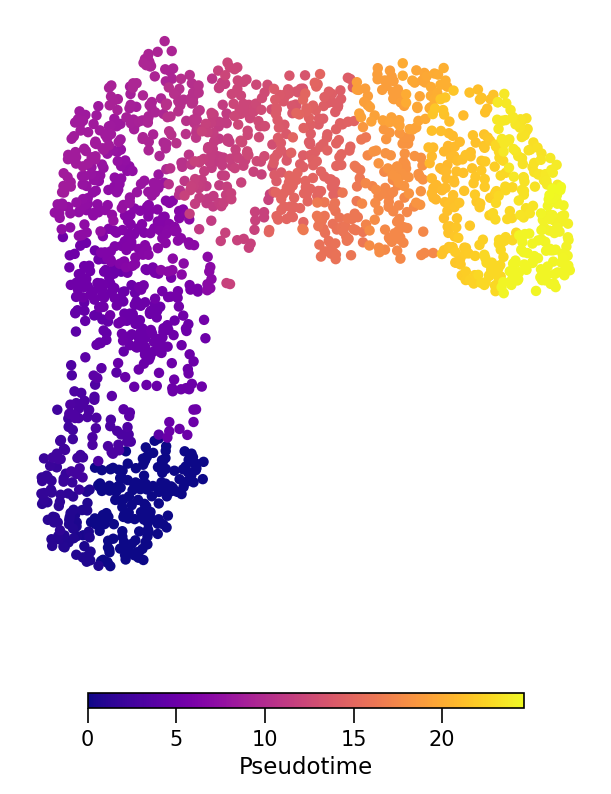

In [58]:
f, ax = plt.subplots(figsize=(5,5))

sc = ax.scatter(anno_sub['UMAP_1'] *-1, 
                anno_sub['UMAP_2'], 
                c=anno_sub['pseudotime'], 
                s=25, 
                cmap='plasma', 
                linewidth=0, 
                edgecolor='k'
)
plt.axis('off')

axins = inset_axes(ax,
                   width="50%",  
                   height="2.5%",
                   loc='lower left',
                   bbox_to_anchor=(.125, -.2, 1.5, 1),
                   bbox_transform=ax.transAxes,
                   borderpad=0,
                   )
cbar = f.colorbar(sc, ax=ax, cax=axins, orientation='horizontal', pad=.06)
cbar.ax.set_xlabel('Pseudotime', fontsize=11, labelpad=3)
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')

_____

In [29]:
chrom = 'X'

In [30]:
incl_idx = oe_dam_cas[list(oe_dam_cas)[0]][chrom] > .101

incl_idx.size, incl_idx.sum()

(1711, 1511)

In [31]:
thrs = 1.5

In [32]:
states = {0:'No X-inactivation',1:'Undertermined',2:'CAST_EiJ inactivated',3:'129S1_SvImJ inactivated'}

states

{0: 'No X-inactivation',
 1: 'Undertermined',
 2: 'CAST_EiJ inactivated',
 3: '129S1_SvImJ inactivated'}

In [33]:
bcs, state = list(), list()
for i,g in enumerate(bc_dict):
    X = np.mean([fftconvolve(oe_chic_cas[bc][chrom][incl_idx], W, mode='same') for bc in bc_dict[g]], axis=1)
    y = np.mean([fftconvolve(oe_chic_129[bc][chrom][incl_idx], W, mode='same') for bc in bc_dict[g]], axis=1)
    
    idx_act = (X < thrs) & (y < thrs)
    idx_un = (X > thrs) & (y > thrs)
    idx_cas = (X > thrs) & (y < thrs)
    idx_129 = (y > thrs) & (X < thrs)
    
    idx = np.concatenate((idx_act.reshape(idx_act.shape[0],1), idx_un.reshape(idx_un.shape[0],1), 
                          idx_cas.reshape(idx_cas.shape[0],1), idx_129.reshape(idx_129.shape[0],1)), axis=1)
    
    bcs.append(bc_dict[g])
    state.append(idx)
    
bcs, state = np.hstack(bcs), np.vstack(state)

bcs.shape, state.sum(0)

((1656,), array([994,  20, 169, 473]))

In [34]:
#make sure `bcs` has same order as `anno_sub.index`
d = dict(zip(bcs, range(bcs.size)))
sort_idx = [d[bc] for bc in anno_sub.index]

bcs =  bcs[sort_idx]
state = state[sort_idx]

____

In [35]:
dam3d = np.array([[fftconvolve(oe_dam_cas[bc][chrom], W, mode='same'),
                   fftconvolve(oe_dam_129[bc][chrom], W, mode='same')] 
                  for bc in bcs]
)
chic3d = np.array([[fftconvolve(oe_chic_cas[bc][chrom], W, mode='same'),
                    fftconvolve(oe_chic_129[bc][chrom], W, mode='same')] 
                   for bc in bcs]
)

dam3d.shape, chic3d.shape

((1656, 2, 1711), (1656, 2, 1711))

In [36]:
dam2d = dam3d[:,:,lb1_k27_idx].mean(2)
chic2d = chic3d[:,:,lb1_k27_idx].mean(2)

dam2d.shape, chic2d.shape

((1656, 2), (1656, 2))

In [37]:
argsort2d = np.argsort(chic2d, axis=1)

argsort2d.shape

(1656, 2)

____

Text(0, 0.5, 'Xi( H3K27me3 )')

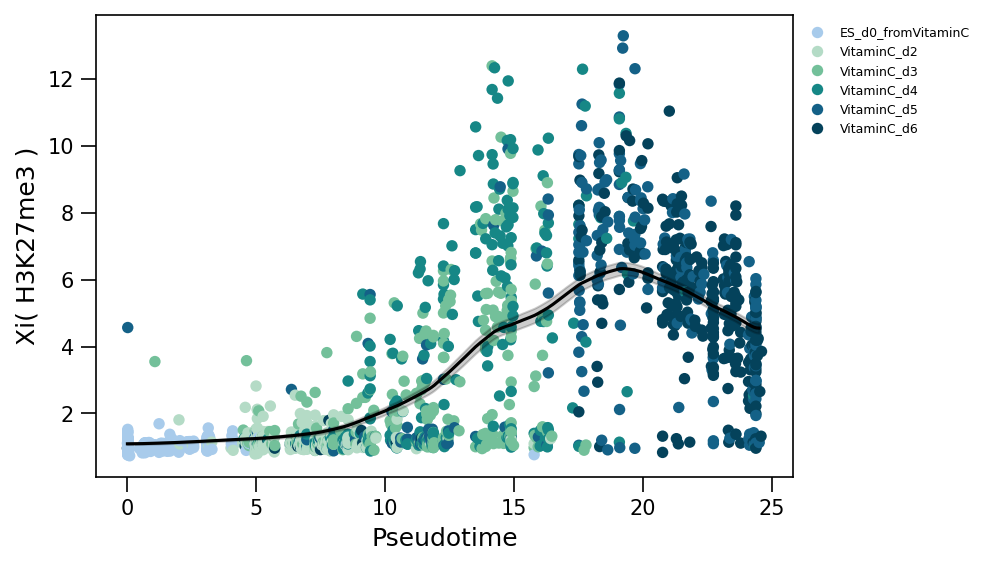

In [39]:
y = np.take_along_axis(chic2d, argsort2d, axis=1)[:,1]
xhat, yhat, yhat_sem = sccu.RNR(anno_sub['pseudotime'], y, _RADIUS=2, step=.1)

f, ax = plt.subplots(figsize=(6,4)) 

sns.scatterplot(x=anno_sub['pseudotime'], 
                y=y, 
                hue=anno_sub['cell_type'], 
                hue_order=np.unique(anno_sub['cell_type']), 
                palette=[coldict[cell_type] for cell_type in np.unique(anno_sub['cell_type'])],
                s=30, 
                lw=0, 
)
ax.plot(xhat, yhat, color='k')
ax.fill_between(xhat, (yhat - yhat_sem), (yhat + yhat_sem), color='k', alpha=.2)

ax.legend(bbox_to_anchor=(1,1), prop={'size':6}, frameon=False)
ax.set_xlabel('Pseudotime', fontsize=12)
ax.set_ylabel('Xi( H3K27me3 )', fontsize=12)

Text(0, 0.5, 'Xi( Dam-Lmnb1 )')

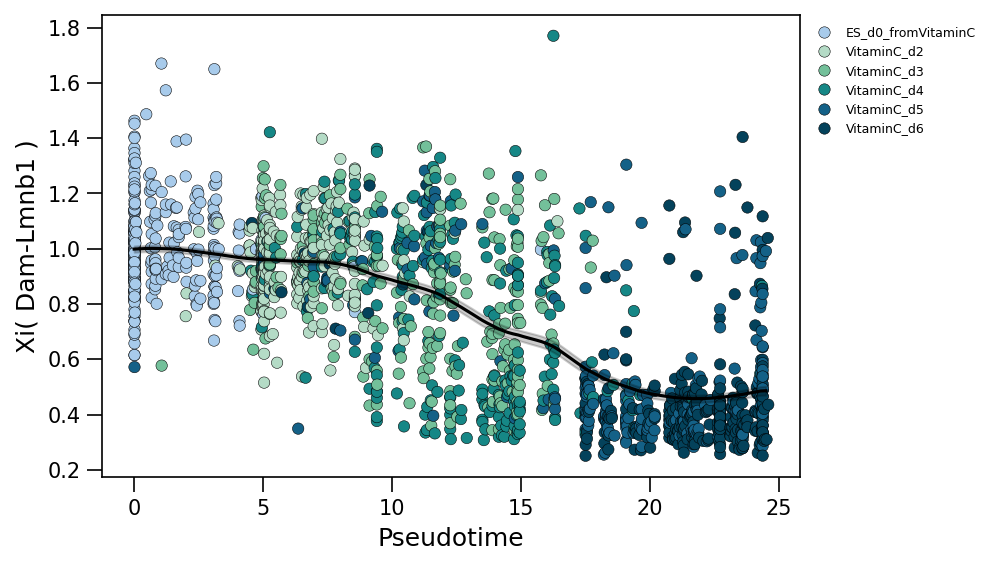

In [46]:
y = np.take_along_axis(dam2d, argsort2d, axis=1)[:,1]
xhat, yhat, yhat_sem = sccu.RNR(anno_sub['pseudotime'], y, _RADIUS=2, step=.1)

f, ax = plt.subplots(figsize=(6,4)) 

sns.scatterplot(x=anno_sub['pseudotime'], 
                y=y, 
                hue=anno_sub['cell_type'], 
                hue_order=np.unique(anno_sub['cell_type']), 
                palette=[coldict[cell_type] for cell_type in np.unique(anno_sub['cell_type'])],
                s=30, 
                linewidth=.25, 
                edgecolor='k'
)
ax.plot(xhat, yhat, color='k')
ax.fill_between(xhat, (yhat - yhat_sem), (yhat + yhat_sem), color='k', alpha=.2)

ax.legend(bbox_to_anchor=(1,1), prop={'size':6}, frameon=False)
ax.set_xlabel('Pseudotime', fontsize=12)
ax.set_ylabel('Xi( Dam-Lmnb1 )', fontsize=12)

____

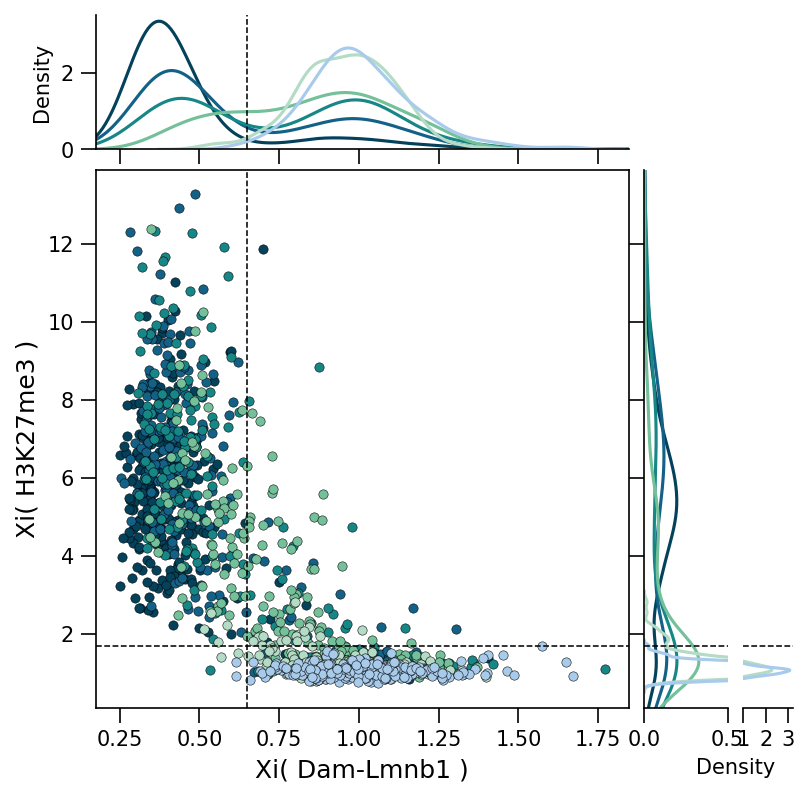

In [57]:
X = np.take_along_axis(dam2d, argsort2d, axis=1)[:,1]
y = np.take_along_axis(chic2d, argsort2d, axis=1)[:,1]

f, ax = plt.subplots(2, 3, figsize=(6,6), gridspec_kw={'height_ratios':[.2,.8],
                                                       'width_ratios':[.8,.125,.075],
                                                       'hspace':.06,
                                                       'wspace':.07}, 
)

for cell_type in np.unique(anno_sub['cell_type'])[::-1]:
        idx = anno_sub['cell_type'] == cell_type
        sns.scatterplot(x=X[idx], 
                        y=y[idx], 
                        color=coldict[cell_type],
                        s=20, 
                        linewidth=.25, 
                        edgecolor='k',
                        label=cell_type,
                        ax=ax[1,0]
        )
sns.kdeplot(x=X, 
            hue=anno_sub['cell_type'], 
            hue_order=np.unique(anno_sub['cell_type']),
            palette=[coldict[cell_type] for cell_type in np.unique(anno_sub['cell_type'])], 
            common_norm=False,
            ax=ax[0,0]
)
sns.kdeplot(y=y, 
            hue=anno_sub['cell_type'], 
            hue_order=np.unique(anno_sub['cell_type']), 
            palette=[coldict[cell_type] for cell_type in np.unique(anno_sub['cell_type'])],
            common_norm=False,
            ax=ax[1,1]
)
sns.kdeplot(y=y, 
            hue=anno_sub['cell_type'], 
            hue_order=np.unique(anno_sub['cell_type']), 
            palette=[coldict[cell_type] for cell_type in np.unique(anno_sub['cell_type'])],
            common_norm=False,
            ax=ax[1,2]
)

ax[1,0].set_xlabel('Xi( Dam-Lmnb1 )', fontsize=12)
ax[1,0].set_ylabel('Xi( H3K27me3 )', fontsize=12)

ax[0,1].remove()
ax[0,2].remove()

ax[0,0].set_xlim(ax[1,0].get_xlim())
ax[1,1].set_ylim(ax[1,0].get_ylim())
ax[1,2].set_ylim(ax[1,0].get_ylim())
ax[1,1].set_yticklabels([])
ax[1,2].set_yticks([])
ax[0,0].set_xticklabels([])
ax[0,0].get_legend().remove()
ax[1,0].get_legend().remove()
ax[1,1].get_legend().remove()
ax[1,2].get_legend().remove()

ax[0,0].spines[['right','top']].set_visible(False)
ax[1,1].spines[['right','top']].set_visible(False)
ax[1,2].spines[['left','top','right']].set_visible(False)

ax[1,1].set_xlim(0,.5)
ax[1,2].set_xlim(1)

ax[1,1].set_xlabel('Density', x=1.1)
ax[1,2].set_xlabel('')


lb1_thrs = .65
k27_thrs = 1.7
for i in range(ax.shape[0]):
    ax[i,0].axvline(lb1_thrs, color='k', lw=.75, ls='--')
    ax[1,i].axhline(k27_thrs, color='k', lw=.75, ls='--')
ax[1,2].axhline(k27_thrs, color='k', lw=.75, ls='--')

___

In [67]:
smooth_stddev = 350000
w = gaussian(ceil(smooth_stddev / BINSIZE * 6 / 2) * 2 + 1, smooth_stddev / BINSIZE)
w /= w.sum()

In [68]:
dam3d = np.array([[fftconvolve(oe_dam_cas[bc][chrom], w, mode='same'),
                          fftconvolve(oe_dam_129[bc][chrom], w, mode='same')] 
                         for bc in bcs]
)
chic3d = np.array([[fftconvolve(oe_chic_cas[bc][chrom], w, mode='same'),
                           fftconvolve(oe_chic_129[bc][chrom], w, mode='same')] 
                          for bc in bcs]
)

dam3d.shape, chic3d.shape

((1656, 2, 1711), (1656, 2, 1711))

In [70]:
X = np.log2(np.take_along_axis(dam3d, np.atleast_3d(argsort2d), axis=1)[:,1,:])
y = np.log2(np.take_along_axis(chic3d, np.atleast_3d(argsort2d), axis=1)[:,1,:])

X.shape, y.shape

((1656, 1711), (1656, 1711))

Text(0.5, 1.0, 'Xi')

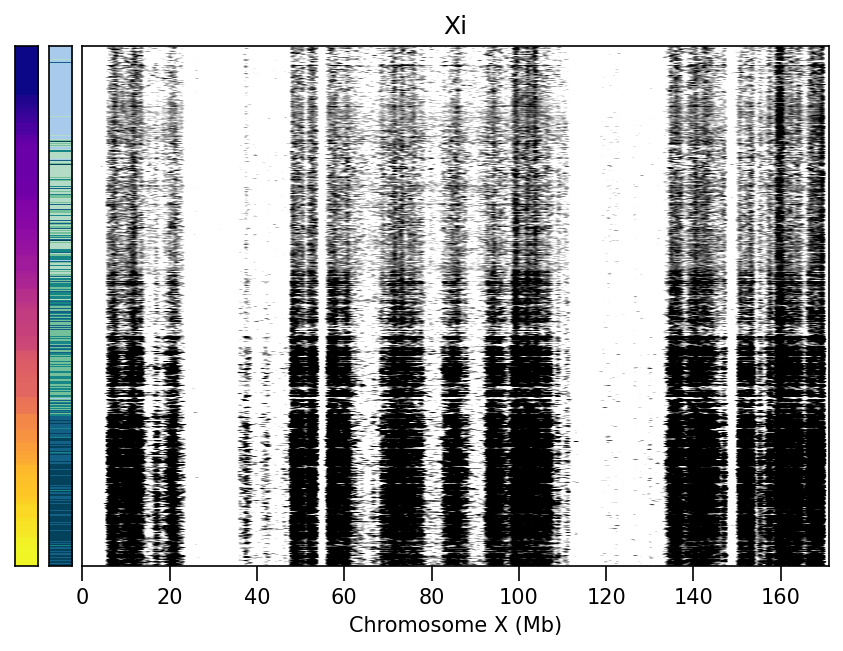

In [71]:
xaxis = np.arange(0,X.shape[1]*BINSIZE,BINSIZE) / 1e6

f, ax = plt.subplots(1, 3, figsize=(7,4.5), gridspec_kw={'width_ratios':[.03,.03,.97],'wspace':.04})

ax[0].pcolorfast(anno_sub['pseudotime'].values.reshape(-1,1)[::-1], 
                 cmap='plasma')

d = dict(zip(np.unique(anno_sub['cell_type']), range(6)))
ax[1].pcolorfast(np.array([d[k] for k in anno_sub['cell_type']])[::-1].reshape(-1,1), 
                 cmap=cmap.from_list('cbar',[coldict[k] for k in d])
)

ax[2].imshow(y, 
             aspect='auto', 
             cmap='binary', 
             vmin=-1, 
             vmax=1, 
             extent=np.hstack([xaxis[[0,-1]], X.shape[0], 0])
)

ax[2].set_xlabel('Chromosome %s (Mb)' %chrom)

for i in (0,1):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
ax[2].set_yticks([])
ax[2].set_title('Xi')

[]

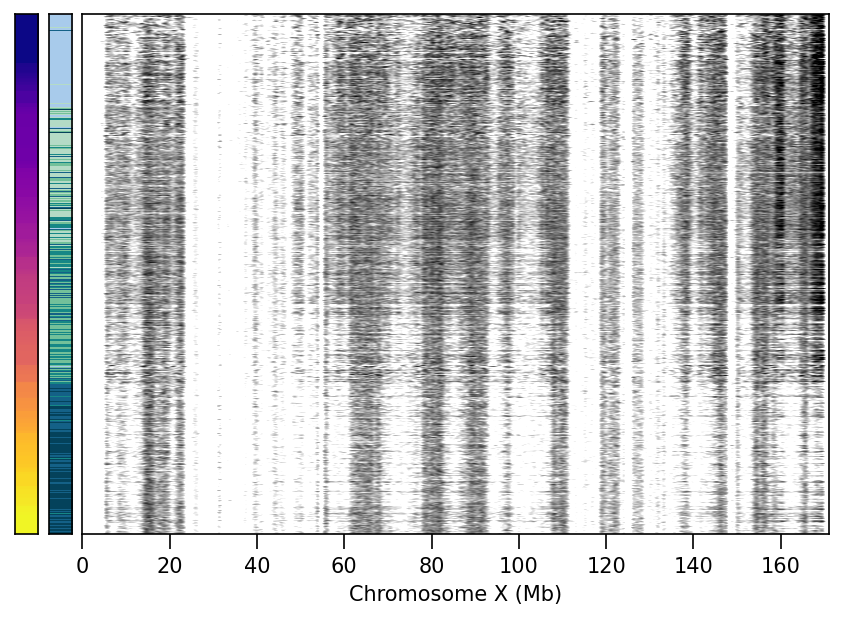

In [72]:
xaxis = np.arange(0,X.shape[1]*BINSIZE,BINSIZE) / 1e6

f, ax = plt.subplots(1, 3, figsize=(7,4.5), gridspec_kw={'width_ratios':[.03,.03,.97],'wspace':.04})

ax[0].pcolorfast(anno_sub['pseudotime'].values.reshape(-1,1)[::-1], 
                 cmap='plasma')

d = dict(zip(np.unique(anno_sub['cell_type']), range(6)))
ax[1].pcolorfast(np.array([d[k] for k in anno_sub['cell_type']])[::-1].reshape(-1,1), 
                 cmap=cmap.from_list('cbar',[coldict[k] for k in d])
)

ax[2].imshow(X, 
             aspect='auto', 
             cmap='binary', 
             vmin=-1.5, 
             vmax=1.5, 
             extent=np.hstack([xaxis[[0,-1]], X.shape[0], 0])
)

ax[2].set_xlabel('Chromosome %s (Mb)' %chrom)

for i in (0,1):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
ax[2].set_yticks([])

____

In [75]:
#Xa: ``[:,0,:]`` Xi: ``[:,1:,]``
X = (np.take_along_axis(dam3d, np.atleast_3d(argsort2d), axis=1)[:,1,:] > 1).astype(int)
y = (np.take_along_axis(chic3d, np.atleast_3d(argsort2d), axis=1)[:,1,:] > 1.7).astype(int)

Z = X + y
Z[y == 1] += 1
Z = Z[::-1]

Z.shape

(1656, 1711)

(5.0, 25.0)

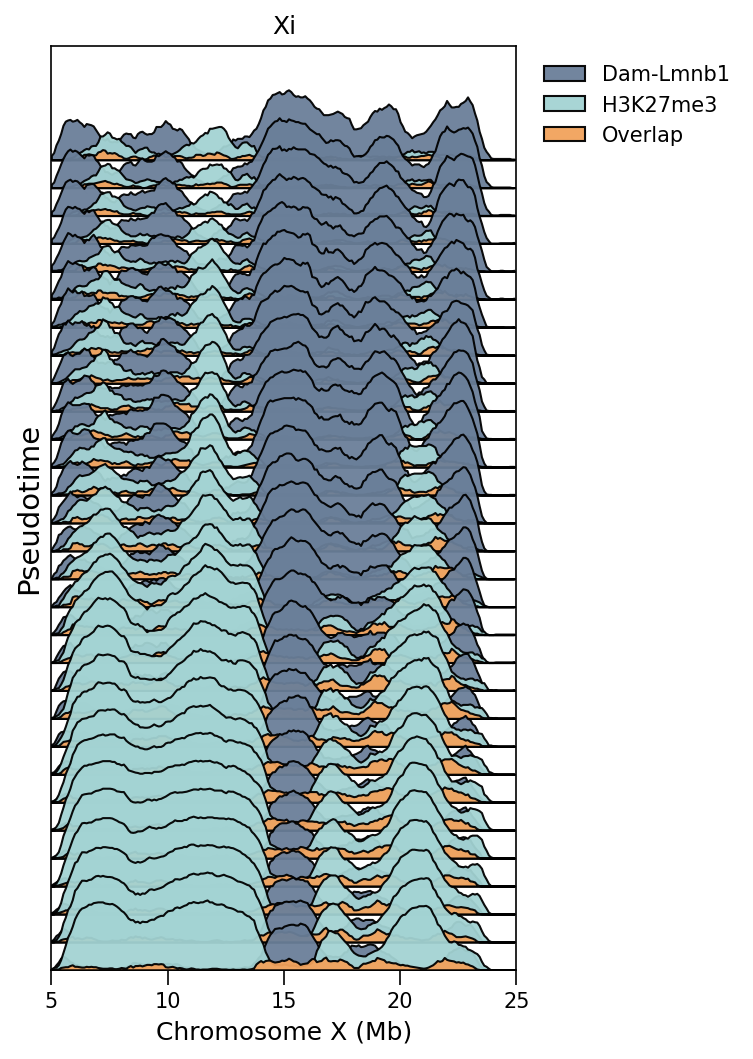

In [80]:
s = 50
e = 250

xaxis = (np.arange(s*BINSIZE,e*BINSIZE,BINSIZE) / 1e6)

window_size = 200
step_size = 50
window_max = Z.shape[0] - window_size
_range = range(0,window_max,step_size)

f, ax = plt.subplots(figsize=(4,8))

dist = .4
for index,i in enumerate(_range):
    
    _x = (Z[i:i+window_size, s:e] == 1).mean(0)
    _y = (Z[i:i+window_size, s:e] == 2).mean(0)
    _z = (Z[i:i+window_size, s:e] == 3).mean(0)
    
    #scale to same range
    _min = np.r_[_x, _y, _z].min()
    _max = np.r_[_x, _y, _z].max()
    
    zorder = len(_range)-index
    for ploti,v in enumerate((_x,_y,_z)):
        v_scale = ((v - _min) / (_max - _min)) + dist*index
        ax.fill_between(xaxis, 
                        dist*index,
                        v_scale, 
                        color=['#6A7F99','#A3D3D3','#F2A25C'][ploti], 
                        label=['Dam-Lmnb1','H3K27me3','Overlap'][ploti],
                        edgecolor='black', 
                        zorder=zorder, 
                        alpha=.95
        )

legend_without_duplicate_labels(ax, bbox_to_anchor=(1.5,1), frameon=False)
ax.set_ylabel('Pseudotime', fontsize=14)
ax.set_xticks(np.arange((s*BINSIZE)/1e6,((e*BINSIZE)/1e6)+.1,5))
ax.set_ylim(0)
ax.set_yticks([])
ax.set_xlabel('Chromosome %s (Mb)' %chrom, fontsize=12)
ax.set_title('Xi')
ax.set_xlim(5,25)

_____

Text(0.5, 0, 'Time')

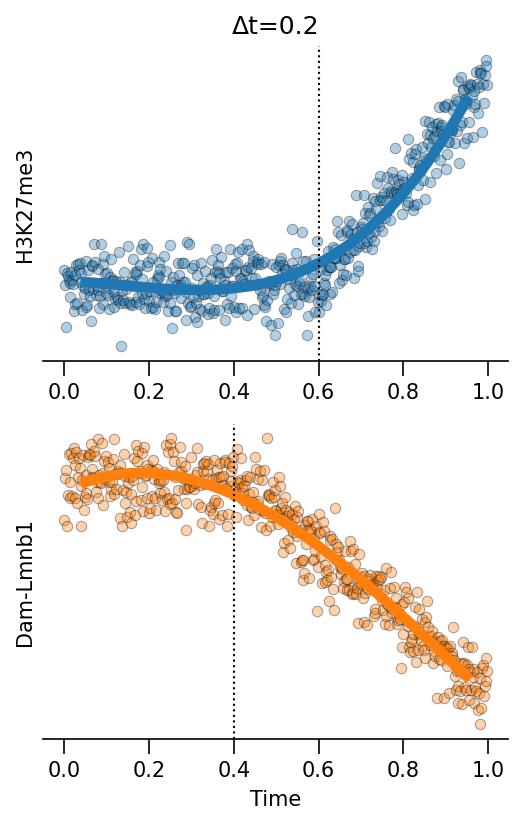

In [85]:
n_obs = 500
xaxis = np.arange(0,1,1/n_obs)

f, ax = plt.subplots(2, 1, figsize=(4,6))

switch = .6
t_normal_up = simulate_dynamics(n_obs, switch, direction=1, noise_level=.1, seed=3)
X_line, y_line, ci = sccu.polynomial_regression(xaxis, t_normal_up, 3, pad=-.05)

sns.scatterplot(x=xaxis, 
                y=t_normal_up, 
                linewidth=.5,
                alpha=.35,
                edgecolor='k',
                s=25,
                ax=ax[0]
)

ax[0].plot(X_line, y_line, lw=5)
ax[0].axvline(switch, color='k', lw=1, ls=':')
ax[0].set_ylabel('H3K27me3')

switch = .4
t_normal_down = simulate_dynamics(n_obs, switch, direction=-1, noise_level=.1, seed=0)
X_line, y_line, ci = sccu.polynomial_regression(xaxis, t_normal_down, 3, pad=-.05)

sns.scatterplot(x=xaxis, 
                y=t_normal_down, 
                linewidth=.5,
                alpha=.35,
                color=COLORS[1],
                edgecolor='k',
                s=25,
                ax=ax[1]
)

ax[1].plot(X_line, y_line, color=COLORS[1], lw=5)
ax[1].axvline(switch, color='k', lw=1, ls=':')
ax[1].set_ylabel('Dam-Lmnb1')

for i in range(ax.size):
    ax[i].spines[['right','left','top']].set_visible(False)
    #ax[i].set_xticks([])
    ax[i].set_yticks([])
    
ax[0].set_title('\u0394t=0.2')
ax[-1].set_xlabel('Time')

Text(0, 0.5, 'H3K27me3')

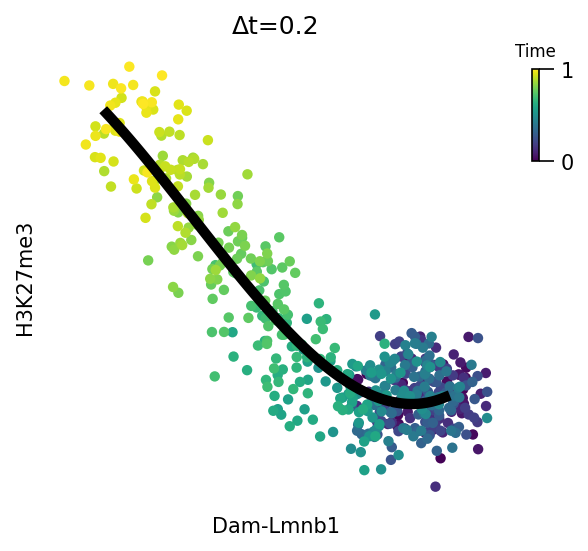

In [86]:
f, ax = plt.subplots(figsize=(4,4))

sct = ax.scatter(t_normal_down, 
           t_normal_up,
           c=xaxis,
           linewidth=0,
           edgecolor='k',
           s=25
)


X_line, y_line, ci = sccu.polynomial_regression(t_normal_down, t_normal_up, 3, pad=-.1)
ax.plot(X_line, y_line, color='k', lw=5)

ax.spines[['right','left','top','bottom']].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

axins = inset_axes(ax,
   width="1%",  # width = 5% of parent_bbox width
   height="20%",  # height : 50%
   loc='lower left',
   bbox_to_anchor=(1.05, .75, 1.5, 1),
   bbox_transform=ax.transAxes,
   borderpad=0,
   )
cbar = f.colorbar(sct, ax=ax, cax=axins, pad=.06, ticks=[0,xaxis.max()])
cbar.ax.set_title('Time', fontsize=8)
cbar.ax.set_yticklabels([0,1])
ax.set_title('\u0394t=0.2')

ax.set_xlabel('Dam-Lmnb1')
ax.set_ylabel('H3K27me3')

Text(0, 0.5, 'H3K27me3')

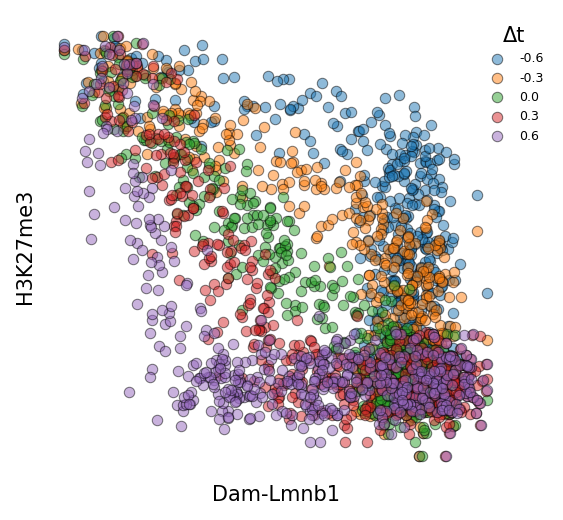

In [89]:
f, ax = plt.subplots(figsize=(4,4),)

i = 0
for s0,s1 in zip([.2,.35,.5,.65,.8],[.2,.35,.5,.65,.8][::-1]):
    t_normal_up = simulate_dynamics(n_obs, s0, direction=1, noise_level=.075, seed=3)
    t_normal_down = simulate_dynamics(n_obs, s1, direction=-1, noise_level=.075, seed=0)

    ax.scatter(t_normal_down, 
               t_normal_up,
               color=COLORS[i],
               linewidth=.5,
               edgecolor='k',
               alpha=.5,
               s=25, 
               label=round(s0-s1,1)
    )
    i += 1
    
ax.legend(prop={'size':6}, title='\u0394t', bbox_to_anchor=(1.1,1), frameon=False)

ax.spines[['right','left','top','bottom']].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

ax.set_xlabel('Dam-Lmnb1')
ax.set_ylabel('H3K27me3')

____

# Dam-K27me3 & Lmnb1

In [102]:
construct = 'Dam-scFv-K27me3'
antibody = 'LmnB1'
cell_type = 'VitaminC'

In [103]:
anno_sub = anno.loc[(anno.index.isin(list(oe_dam_cas)) & 
                     anno.index.isin(list(oe_dam_129)) & 
                     anno.index.isin(list(oe_chic_cas)) & 
                     anno.index.isin(list(oe_chic_129)))
]

anno_sub.shape

(7084, 17)

In [104]:
anno_sub = anno_sub[(anno_sub['construct'] == construct) &
                    (anno_sub['antibody'] == antibody) & 
                    (anno_sub['cell_type'].str.contains(cell_type) | anno_sub['cell_type'].str.contains('ES'))]

anno_sub.shape

(1919, 17)

In [105]:
gb = anno_sub.groupby(['construct','antibody','cell_type'])

gb.size().to_frame('Cells')

Cells
construct       antibody cell_type         
Dam-scFv-K27me3 LmnB1    ES_d0          153
                         VitaminC_d2    148
                         VitaminC_d3   1157
                         VitaminC_d4    153
                         VitaminC_d5    159
                         VitaminC_d6    149

In [106]:
np.random.seed(4)

n = 159
_bcs = np.random.choice(anno_sub[anno_sub['cell_type'] == 'VitaminC_d3'].index, n, replace=False)

anno_sub = pd.DataFrame(anno_sub[anno_sub.index.isin(_bcs) | (anno_sub['cell_type'] != 'VitaminC_d3')])

anno_sub.shape

(921, 17)

In [107]:
gb = anno_sub.groupby(['construct','antibody','cell_type'])

gb.size().to_frame('Cells')

Cells
construct       antibody cell_type         
Dam-scFv-K27me3 LmnB1    ES_d0          153
                         VitaminC_d2    148
                         VitaminC_d3    159
                         VitaminC_d4    153
                         VitaminC_d5    159
                         VitaminC_d6    149

In [108]:
bc_dict = gb.groups

list(bc_dict), len(bc_dict)

([('Dam-scFv-K27me3', 'LmnB1', 'ES_d0'),
  ('Dam-scFv-K27me3', 'LmnB1', 'VitaminC_d2'),
  ('Dam-scFv-K27me3', 'LmnB1', 'VitaminC_d3'),
  ('Dam-scFv-K27me3', 'LmnB1', 'VitaminC_d4'),
  ('Dam-scFv-K27me3', 'LmnB1', 'VitaminC_d5'),
  ('Dam-scFv-K27me3', 'LmnB1', 'VitaminC_d6')],
 6)

____

In [115]:
chrom = 'X'

In [116]:
thrs = .95

In [117]:
states = {0:'No X-inactivation',1:'Undertermined',2:'CAST_EiJ inactivated',3:'129S1_SvImJ inactivated'}

states

{0: 'No X-inactivation',
 1: 'Undertermined',
 2: 'CAST_EiJ inactivated',
 3: '129S1_SvImJ inactivated'}

In [118]:
bcs, state = list(), list()
for i,g in enumerate(bc_dict):
    X = np.mean([fftconvolve(oe_dam_cas[bc][chrom][incl_idx], W, mode='same') for bc in bc_dict[g]], axis=1)
    y = np.mean([fftconvolve(oe_dam_129[bc][chrom][incl_idx], W, mode='same') for bc in bc_dict[g]], axis=1)
    
    idx_act = (X < thrs) & (y < thrs)
    idx_un = (X > thrs) & (y > thrs)
    idx_cas = (X > thrs) & (y < thrs)
    idx_129 = (y > thrs) & (X < thrs)
    
    idx = np.concatenate((idx_act.reshape(idx_act.shape[0],1), idx_un.reshape(idx_un.shape[0],1), 
                          idx_cas.reshape(idx_cas.shape[0],1), idx_129.reshape(idx_129.shape[0],1)), axis=1)
    
    bcs.append(bc_dict[g])
    state.append(idx)
    
bcs, state = np.hstack(bcs), np.vstack(state)

bcs.shape, state.sum(0)

((921,), array([528,  28, 129, 236]))

In [119]:
#make sure ``bcs`` has same order as ``anno_sub.index``
d = dict(zip(bcs, range(bcs.size)))
sort_idx = [d[bc] for bc in anno_sub.index]

bcs =  bcs[sort_idx]
state = state[sort_idx]

____

In [120]:
smooth_stddev = 350000
w = gaussian(ceil(smooth_stddev / BINSIZE * 6 / 2) * 2 + 1, smooth_stddev / BINSIZE)
w /= w.sum()

In [121]:
dam3d = np.array([[fftconvolve(oe_dam_cas[bc][chrom], w, mode='same'),
                   fftconvolve(oe_dam_129[bc][chrom], w, mode='same')] 
                  for bc in bcs]
)
chic3d = np.array([[fftconvolve(oe_chic_cas[bc][chrom], w, mode='same'),
                    fftconvolve(oe_chic_129[bc][chrom], w, mode='same')] 
                   for bc in bcs]
)

dam3d.shape, chic3d.shape

((921, 2, 1711), (921, 2, 1711))

In [122]:
dam2d = dam3d[:,:,lb1_k27_idx].mean(2)
chic2d = chic3d[:,:,lb1_k27_idx].mean(2)

dam2d.shape, chic2d.shape

((921, 2), (921, 2))

In [123]:
argsort2d = np.argsort(dam2d, axis=1)

argsort2d.shape

(921, 2)

____

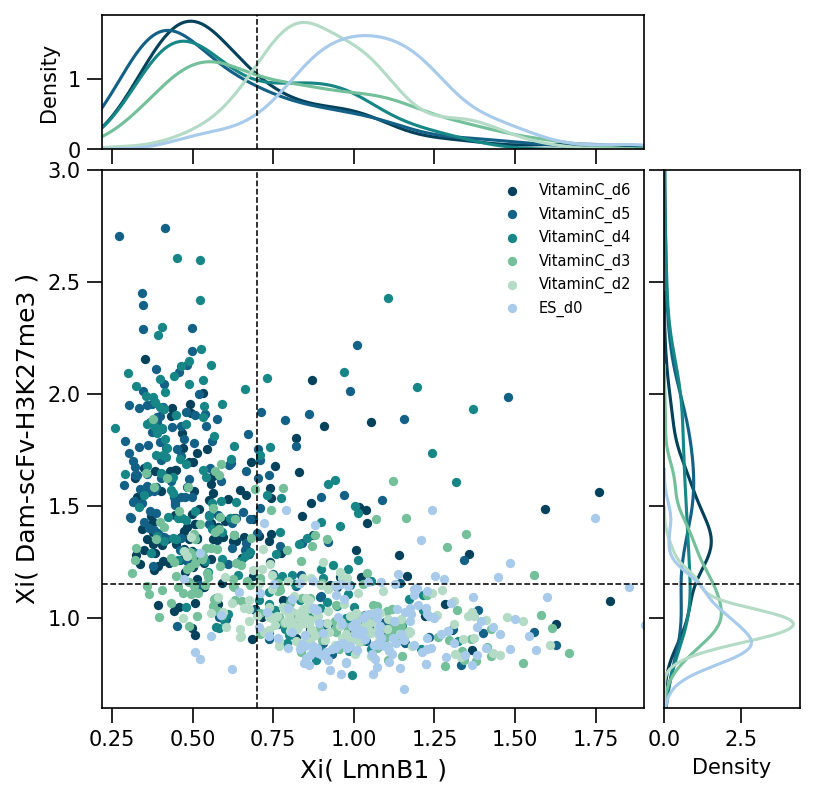

In [126]:
X = np.take_along_axis(chic2d, argsort2d, axis=1)[:,1]
y = np.take_along_axis(dam2d, argsort2d, axis=1)[:,1]

f, ax = plt.subplots(2, 2, figsize=(6,6), gridspec_kw={'height_ratios':[.2,.8],
                                                       'width_ratios':[.8,.2],
                                                       'hspace':.06,
                                                       'wspace':.06},
)

for cell_type in np.unique(anno_sub['cell_type'])[::-1]:
        idx = anno_sub['cell_type'] == cell_type
        sns.scatterplot(x=X[idx], 
                        y=y[idx], 
                        color=coldict[cell_type],
                        s=20, 
                        linewidth=0, 
                        label=cell_type,
                        ax=ax[1,0]
        )
sns.kdeplot(x=X, 
            hue=anno_sub['cell_type'], 
            hue_order=np.unique(anno_sub['cell_type']),
            palette=[coldict[cell_type] for cell_type in np.unique(anno_sub['cell_type'])], 
            common_norm=False,
            ax=ax[0,0]
)

sns.kdeplot(y=y, 
            hue=anno_sub['cell_type'], 
            hue_order=np.unique(anno_sub['cell_type']), 
            palette=[coldict[cell_type] for cell_type in np.unique(anno_sub['cell_type'])],
            common_norm=False,
            ax=ax[1,1]
)

ax[1,0].set_xlim(.22,1.9)
ax[1,0].set_ylim(.6,3)

ax[1,0].set_xlabel('Xi( LmnB1 )', fontsize=12)
ax[1,0].set_ylabel('Xi( Dam-scFv-H3K27me3 )', fontsize=12)
ax[1,0].legend(prop={'size':7}, frameon=False)

ax[0,1].remove()
ax[0,0].set_xlim(ax[1,0].get_xlim())
ax[1,1].set_ylim(ax[1,0].get_ylim())
ax[1,1].set_yticklabels([])
ax[0,0].set_xticklabels([])
ax[0,0].get_legend().remove()
ax[1,1].get_legend().remove()

lb1_thrs = .7
k27_thrs = 1.15
for i in range(ax.shape[0]):
    ax[i,0].axvline(lb1_thrs, color='k', lw=.75, ls='--')
    ax[1,i].axhline(k27_thrs, color='k', lw=.75, ls='--')